In [41]:
!pip install -q rpy2

In [42]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# The Data

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
%%R

df.train <- read.csv('/content/drive/MyDrive/Colab Notebooks/ml r/03 Machine Learning with R/titanic_train.csv')

In [45]:
%%R

head(df.train)


  PassengerId Survived Pclass
1           1        0      3
2           2        1      1
3           3        1      3
4           4        1      1
5           5        0      3
6           6        0      3
                                                 Name    Sex Age SibSp Parch
1                             Braund, Mr. Owen Harris   male  22     1     0
2 Cumings, Mrs. John Bradley (Florence Briggs Thayer) female  38     1     0
3                              Heikkinen, Miss. Laina female  26     0     0
4        Futrelle, Mrs. Jacques Heath (Lily May Peel) female  35     1     0
5                            Allen, Mr. William Henry   male  35     0     0
6                                    Moran, Mr. James   male  NA     0     0
            Ticket    Fare Cabin Embarked
1        A/5 21171  7.2500              S
2         PC 17599 71.2833   C85        C
3 STON/O2. 3101282  7.9250              S
4           113803 53.1000  C123        S
5           373450  8.0500              S

# Exploratory Data Analysis (EDA)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'http://cran.us.r-project.org/src/contrib/Amelia_1.8.3.tar.gz'
Content type 'application/x-gzip' length 1568806 bytes (1.5 MB)
downloaded 1.5 MB


The downloaded source packages are in
	‘/tmp/Rtmp2HJ4V7/downloaded_packages’


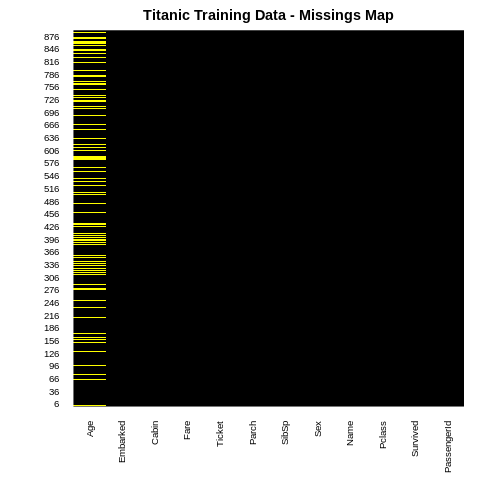

In [46]:
%%R

install.packages('Amelia',repos = 'http://cran.us.r-project.org')
library(Amelia)
missmap(df.train, main="Titanic Training Data - Missings Map",   col=c("yellow", "black"), legend=FALSE)

# Data Visualization with ggplot2

In [47]:
%%R

library(ggplot2)

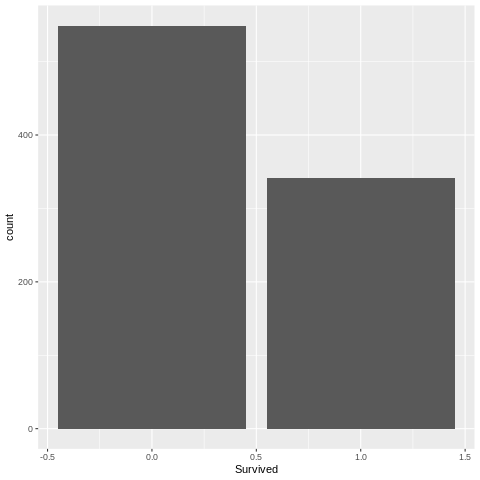

In [48]:
%%R

ggplot(df.train,aes(Survived)) + geom_bar()

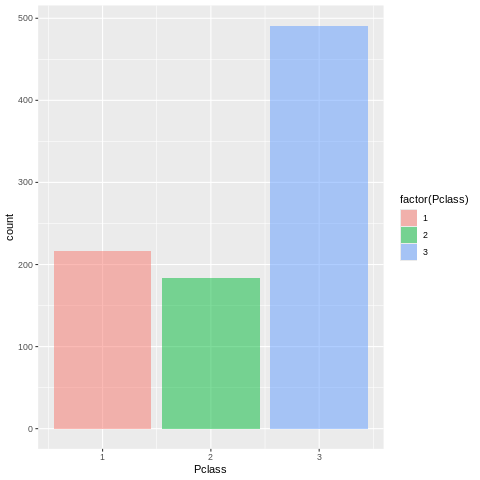

In [49]:
%%R

ggplot(df.train,aes(Pclass)) + geom_bar(aes(fill=factor(Pclass)),alpha=0.5)


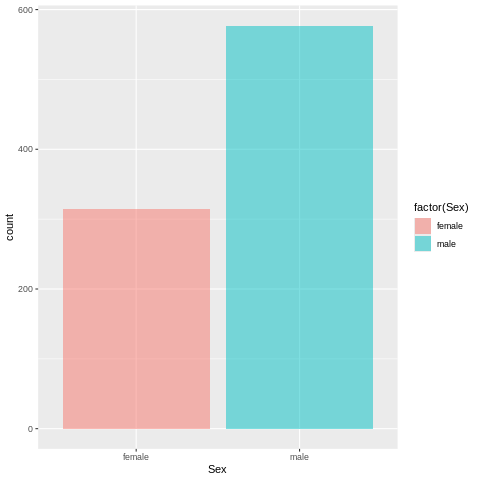

In [50]:
%%R

ggplot(df.train,aes(Sex)) + geom_bar(aes(fill=factor(Sex)),alpha=0.5)

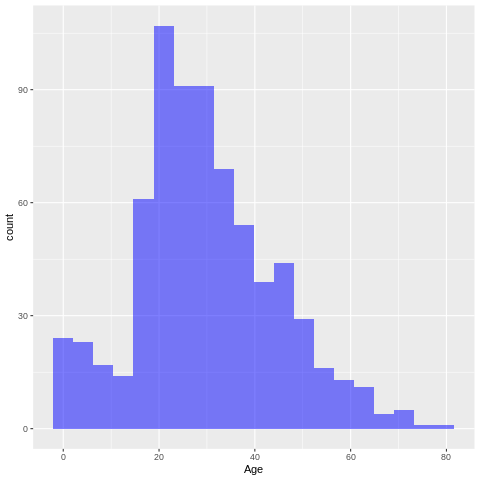

In [51]:
%%R

ggplot(df.train,aes(Age)) + geom_histogram(fill='blue',bins=20,alpha=0.5)

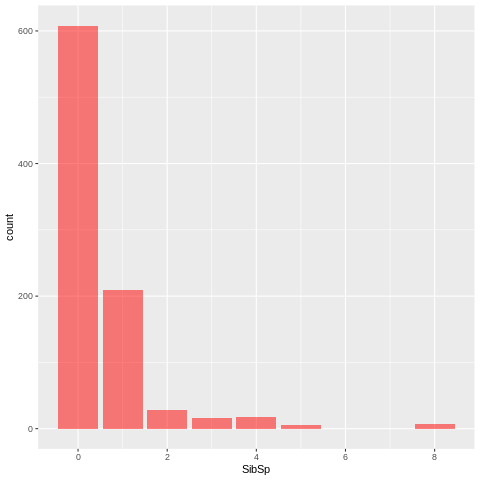

In [52]:
%%R

ggplot(df.train,aes(SibSp)) + geom_bar(fill='red',alpha=0.5)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


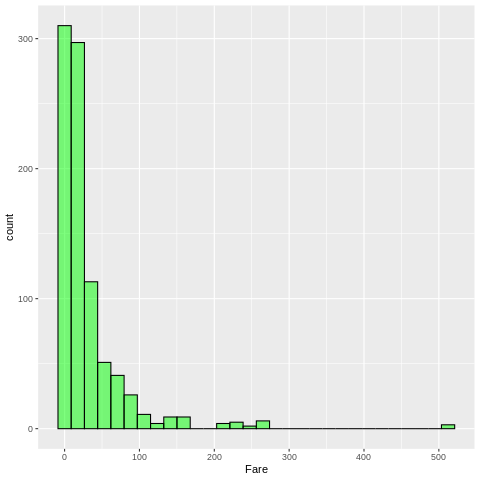

In [53]:
%%R

ggplot(df.train,aes(Fare)) + geom_histogram(fill='green',color='black',alpha=0.5)

# Data Cleaning

We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).


(`stat_boxplot()`). 



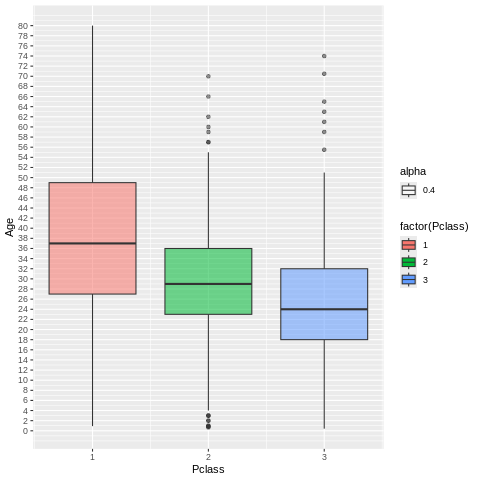

In [54]:
%%R

pl <- ggplot(df.train,aes(Pclass,Age)) + geom_boxplot(aes(group=Pclass,fill=factor(Pclass),alpha=0.4))
pl + scale_y_continuous(breaks = seq(min(0), max(80), by = 2))


We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age

In [55]:
%%R

impute_age <- function(age,class){
    out <- age
    for (i in 1:length(age)){

        if (is.na(age[i])){

            if (class[i] == 1){
                out[i] <- 37

            }else if (class[i] == 2){
                out[i] <- 29

            }else{
                out[i] <- 24
            }
        }else{
            out[i]<-age[i]
        }
    }
    return(out)
}

In [56]:
%%R

fixed.ages <- impute_age(df.train$Age,df.train$Pclass)

In [57]:
%%R

df.train$Age <- fixed.ages

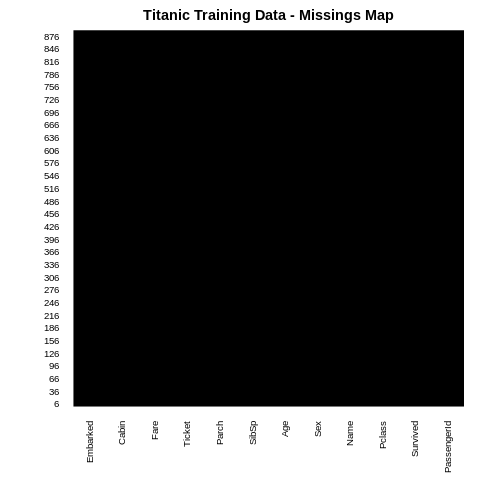

In [58]:
%%R

missmap(df.train, main="Titanic Training Data - Missings Map",    col=c("yellow", "black"), legend=FALSE)

# Building a Logistic Regression Model

In [59]:
%%R

str(df.train)

'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : chr  "male" "female" "female" "female" ...
 $ Age        : num  22 38 26 35 35 24 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...


Let's select the relevant columns for training:

In [60]:
%%R

library(dplyr)

In [61]:
%%R

df.train <- select(df.train,-PassengerId,-Name,-Ticket,-Cabin)

In [62]:
%%R

head(df.train,3)

  Survived Pclass    Sex Age SibSp Parch    Fare Embarked
1        0      3   male  22     1     0  7.2500        S
2        1      1 female  38     1     0 71.2833        C
3        1      3 female  26     0     0  7.9250        S


In [63]:
%%R

str(df.train)

'data.frame':	891 obs. of  8 variables:
 $ Survived: int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass  : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Sex     : chr  "male" "female" "female" "female" ...
 $ Age     : num  22 38 26 35 35 24 54 2 27 14 ...
 $ SibSp   : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch   : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Fare    : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Embarked: chr  "S" "C" "S" "S" ...


In [64]:
%%R

df.train$Survived <- factor(df.train$Survived)
df.train$Pclass <- factor(df.train$Pclass)
df.train$Parch <- factor(df.train$Parch)
df.train$SibSp <- factor(df.train$SibSp)

## Train the Model

In [65]:
%%R

log.model <- glm(formula=Survived ~ . , family = binomial(link='logit'),data = df.train)

In [66]:
%%R

summary(log.model)


Call:
glm(formula = Survived ~ ., family = binomial(link = "logit"), 
    data = df.train)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.845e+01  1.660e+03   0.011 0.991134    
Pclass2     -1.079e+00  3.092e-01  -3.490 0.000484 ***
Pclass3     -2.191e+00  3.161e-01  -6.930 4.20e-12 ***
Sexmale     -2.677e+00  2.040e-01 -13.123  < 2e-16 ***
Age         -3.971e-02  8.758e-03  -4.534 5.79e-06 ***
SibSp1       8.135e-02  2.245e-01   0.362 0.717133    
SibSp2      -2.897e-01  5.368e-01  -0.540 0.589361    
SibSp3      -2.241e+00  7.202e-01  -3.111 0.001862 ** 
SibSp4      -1.675e+00  7.620e-01  -2.198 0.027954 *  
SibSp5      -1.595e+01  9.588e+02  -0.017 0.986731    
SibSp8      -1.607e+01  7.578e+02  -0.021 0.983077    
Parch1       3.741e-01  2.895e-01   1.292 0.196213    
Parch2       3.862e-02  3.824e-01   0.101 0.919560    
Parch3       3.655e-01  1.056e+00   0.346 0.729318    
Parch4      -1.586e+01  1.055e+03  -0.015 0.988007    
Parch5      -

## Predicting using Test Cases

In [67]:
%%R

install.packages('caTools',repos = 'http://cran.us.r-project.org')
library(caTools)
set.seed(101)

split = sample.split(df.train$Survived, SplitRatio = 0.70)

final.train = subset(df.train, split == TRUE)
final.test = subset(df.train, split == FALSE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'http://cran.us.r-project.org/src/contrib/caTools_1.18.3.tar.gz'
Content type 'application/x-gzip' length 65825 bytes (64 KB)
downloaded 64 KB


The downloaded source packages are in
	‘/tmp/Rtmp2HJ4V7/downloaded_packages’


In [68]:
%%R

final.log.model <- glm(formula=Survived ~ . , family = binomial(link='logit'),data = final.train)

In [69]:
%%R

summary(final.log.model)


Call:
glm(formula = Survived ~ ., family = binomial(link = "logit"), 
    data = final.train)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.777e+01  2.400e+03   0.007 0.994091    
Pclass2     -1.230e+00  3.814e-01  -3.225 0.001261 ** 
Pclass3     -2.160e+00  3.841e-01  -5.624 1.87e-08 ***
Sexmale     -2.660e+00  2.467e-01 -10.782  < 2e-16 ***
Age         -3.831e-02  1.034e-02  -3.705 0.000212 ***
SibSp1      -2.114e-02  2.755e-01  -0.077 0.938836    
SibSp2      -4.000e-01  6.463e-01  -0.619 0.536028    
SibSp3      -2.324e+00  8.994e-01  -2.584 0.009765 ** 
SibSp4      -1.196e+00  8.302e-01  -1.440 0.149839    
SibSp5      -1.603e+01  9.592e+02  -0.017 0.986666    
SibSp8      -1.633e+01  1.004e+03  -0.016 0.987019    
Parch1       7.290e-01  3.545e-01   2.056 0.039771 *  
Parch2       1.406e-01  4.504e-01   0.312 0.754892    
Parch3       7.919e-01  1.229e+00   0.645 0.519226    
Parch4      -1.498e+01  1.552e+03  -0.010 0.992300    
Parch5    

In [70]:
%%R

fitted.probabilities <- predict(final.log.model,newdata=final.test,type='response')

In [71]:
%%R

fitted.results <- ifelse(fitted.probabilities > 0.5,1,0)

In [72]:
%%R

misClasificError <- mean(fitted.results != final.test$Survived)
print(paste('Accuracy',1-misClasificError))

[1] "Accuracy 0.798507462686567"


In [73]:
%%R

table(final.test$Survived, fitted.probabilities > 0.5)

   
    FALSE TRUE
  0   140   25
  1    29   74


In [74]:
%%R



NULL
